In [1]:
import sys

sys.path.append('../../')

import numpy as np
import random
import pylab as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

from bayes_opt import BayesianOptimization

from sklearn import datasets
from dal_toolbox.models.resnet import train_one_epoch, evaluate
from dal_toolbox.models.ssl_train_methods.pimodel import train_one_epoch as pi_train_one_epoch
from dal_toolbox.models.ssl_train_methods.pseudolabel import train_one_epoch as pseudo_train_one_epoch

In [6]:
# A key aspect for semi supervised learning is data augmentation. We therefore need a Custom Dataset that
# applys these random augmentations to the samples.

class GaussianNoiseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y, mean=0, std=1, p_noise=0.85):
        super(GaussianNoiseDataset, self).__init__(X, y)
        self.mean = mean
        self.std = std
        self.p_noise = p_noise
        assert p_noise > 0 and p_noise <= 1, "p_noise is a probability and should be between 0 and 1"

    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)
        if torch.randn((1)) < self.p_noise:
            return (X + torch.randn(X.shape) * self.std + self.mean, y)
        else:
            return (X, y)

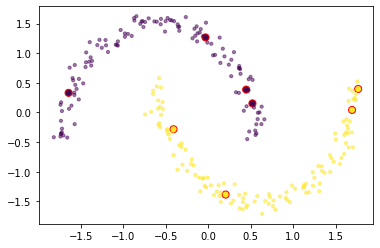

In [7]:
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

random.seed(2)

labeled_idx = random.sample([i for i in range(len(y)) if y[i] == 0], k=4) + random.sample([i for i in range(len(y)) if y[i] == 1], k=4)
unlabeled_idx = [i for i in range(X.shape[0]) if i not in labeled_idx]

X_labeled = X[labeled_idx]
y_labeled = y[labeled_idx]

X_unlabeled = X[unlabeled_idx]
y_unlabeled = y[unlabeled_idx]

lbd_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
val_ds = torch.utils.data.TensorDataset(X, y)
val_loader = DataLoader(val_ds, batch_size=64)
ds = GaussianNoiseDataset(X, y)

plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='red')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5)
plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = 0,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [9]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=20, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=[0, 0.25, 0.5, 0.75, 1], origin=origin)
    #TODO: Test 0.5
    CS2 = plt.contour(CS, levels=CS.levels[::2], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [10]:
# Define a BlackBoxFunction to perform bayesian optimization on pimodel and pseudolabels
class SUPERVISED_BBF(nn.Module):
    def __init__(self, ds, lbd_ds, val_ds):
        super(SUPERVISED_BBF, self).__init__()
        self.val_loader = DataLoader(val_ds, batch_size=64)
        self.criterion = nn.CrossEntropyLoss()
        self.lbd_ds = lbd_ds
        self.ds = ds
        self.n_epochs = 50

    def forward(self, lr, wd):
        torch.manual_seed(0)
        optimizer_params = dict(
            lr=lr,
            weight_decay=wd,
            momentum=.9,
            )

        supervised_model = Net(dropout_rate=0, num_classes=2)
        supervised_optimizer = torch.optim.SGD(supervised_model.parameters(), **optimizer_params)

        supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)

        for i in range(self.n_epochs):
            train_stats = train_one_epoch(supervised_model, supervised_train_loader, self.criterion, supervised_optimizer, device='cuda', epoch=i)

        return evaluate(supervised_model, self.val_loader, {}, self.criterion, device='cuda')['test_acc1']


class PSEUDO_BBF(nn.Module):
    def __init__(self, ds, lbd_ds, val_ds):
        super(PSEUDO_BBF, self).__init__()
        self.val_loader = DataLoader(val_ds, batch_size=64)
        self.criterion = nn.CrossEntropyLoss()
        self.lbd_ds = lbd_ds
        self.ds = ds
        self.n_epochs = 250

    def forward(self, lr, wd, lmd):
        torch.manual_seed(0)
        pseudo_optimizer_params = dict(
            lr=lr,
            weight_decay=wd,
            momentum=.9,
        )

        pseudo_model = Net(dropout_rate=0, num_classes=2)
        pseudo_optimizer = torch.optim.SGD(pseudo_model.parameters(), **pseudo_optimizer_params)

        supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
        unsupervised_loader_1 = DataLoader(ds, batch_size=8, shuffle=True)
        pseudo_loaders = {
            "train_sup": supervised_train_loader,
            "train_unsup": unsupervised_loader_1
        }

        for i in range(self.n_epochs):
            train_stats = pseudo_train_one_epoch(
                model=pseudo_model, dataloaders=pseudo_loaders, criterion=self.criterion, 
                optimizer=pseudo_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=lmd, use_hard_labels=True,
                n_epochs=self.n_epochs, p_cutoff=0.95)
        pseudo_model.eval()

        return evaluate(pseudo_model, self.val_loader, {}, self.criterion, device='cuda')['test_acc1']


class PI_BBF(nn.Module):
    def __init__(self, ds, lbd_ds, val_ds):
        super(PI_BBF, self).__init__()
        self.val_loader = DataLoader(val_ds, batch_size=64)
        self.criterion = nn.CrossEntropyLoss()
        self.lbd_ds = lbd_ds
        self.ds = ds
        self.n_epochs = 250

    def forward(self, lr, wd, lmd):
        torch.manual_seed(0)
        optimizer_params = dict(
            lr=lr,
            weight_decay=wd,
            momentum=.9,
            )

        pi_model = Net(dropout_rate=0, num_classes=2)
        pi_optimizer = torch.optim.SGD(pi_model.parameters(), **optimizer_params)

        random_sampler_weak_1 = RandomSampler(ds, generator=torch.Generator().manual_seed(42))
        random_sampler_weak_2 = RandomSampler(ds, generator=torch.Generator().manual_seed(42))
        supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
        unsupervised_loader_1 = DataLoader(ds, batch_size=8, sampler=random_sampler_weak_1)
        unsupervised_loader_2 = DataLoader(ds, batch_size=8, sampler=random_sampler_weak_2)
        pi_loaders = {
                "train_sup": supervised_train_loader,
                "train_unsup_weak_1": unsupervised_loader_1,
                "train_unsup_weak_2": unsupervised_loader_2
            }


        for i in range(self.n_epochs):
            train_stats = pi_train_one_epoch(
                model=pi_model, dataloaders=pi_loaders, criterion=self.criterion, 
                optimizer=pi_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=lmd,
                n_epochs=self.n_epochs)

        return evaluate(pi_model, self.val_loader, {}, self.criterion, device='cuda')['test_acc1']

In [11]:
# Do BayesOpt on Supervised Model
supervised_pbounds = {
        'wd': (1e-5, 1e-1),
        'lr': (1e-3, 1e-1)
        }

supervised_bbf = SUPERVISED_BBF(ds, lbd_ds, val_ds)

# Create an optimizer
supervised_optimizer = BayesianOptimization(
f=supervised_bbf,
pbounds=supervised_pbounds,
verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
random_state=0,
)

# Try to find maximizing parameter values
supervised_optimizer.maximize(
init_points=25,
n_iter=225,
)

print(supervised_optimizer.max)

supervised_params = supervised_optimizer.max['params']

|   iter    |  target   |    lr     |    wd     |
-------------------------------------------------
Epoch [0] [0/1] eta: 0:00:00 lr: 0.055332536888805156 loss: 0.6993 (0.6993) acc1: 50.0000 (50.0000) time: 0.2986 data: 0.0003 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.055332536888805156 loss: 0.6620 (0.6620) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.055332536888805156 loss: 0.6093 (0.6093) acc1: 87.5000 (87.5000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.055332536888805156 loss: 0.5586 (0.5586) acc1: 87.5000 (87.5000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.055332536888805156 loss: 0.5163 (0.5163) acc1: 75.0000 (75.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.055332536888805156 loss: 0.478

In [12]:
# Repeat on Pseudolabels
pseudo_pbounds = {
        'wd': (1e-5, 1e-1),
        'lr': (1e-3, 1e-1),
        'lmd': (0.1, 10)
        }

pseudo_bbf = PSEUDO_BBF(ds, lbd_ds, val_ds)

# Create an optimizer
pseudo_optimizer = BayesianOptimization(
f=pseudo_bbf,
pbounds=pseudo_pbounds,
verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
random_state=0,
)

# Try to find maximizing parameter values
pseudo_optimizer.maximize(
init_points=25,
n_iter=225,
)

print(pseudo_optimizer.max)

pseudo_params = pseudo_optimizer.max['params']

|   iter    |  target   |    lmd    |    lr     |    wd     |
-------------------------------------------------------------
| 6         | 88.8      | 0.9626    | 0.003002  | 0.08326   |
| 46        | 89.6      | 9.37      | 0.09658   | 0.03719   |
| 58        | 90.0      | 0.977     | 0.001839  | 0.08657   |
| 205       | 90.8      | 6.382     | 0.08009   | 0.0001689 |
{'target': 90.80000305175781, 'params': {'lmd': 6.38214323930645, 'lr': 0.08008745592382485, 'wd': 0.00016886988309763187}}


In [13]:
# Repeat on Pimodel
pi_pbounds = {
        'wd': (1e-5, 1e-1),
        'lr': (1e-3, 1e-1),
        'lmd': (0.1, 10)
        }

pi_bbf = PI_BBF(ds, lbd_ds, val_ds)

# Create an optimizer
pi_optimizer = BayesianOptimization(
f=pi_bbf,
pbounds=pi_pbounds,
verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
random_state=0,
)

# Try to find maximizing parameter values
pi_optimizer.maximize(
init_points=25,
n_iter=225,
)

print(pi_optimizer.max)

pi_params = pi_optimizer.max['params']

|   iter    |  target   |    lmd    |    lr     |    wd     |
-------------------------------------------------------------
| 2         | 86.8      | 5.494     | 0.04294   | 0.06459   |
| 5         | 90.8      | 5.724     | 0.09263   | 0.007113  |
| 9         | 93.2      | 1.271     | 0.06435   | 0.01434   |
| 20        | 94.8      | 2.608     | 0.04716   | 0.02445   |
| 27        | 96.8      | 2.582     | 0.04002   | 0.01957   |
| 80        | 97.6      | 4.457     | 0.02718   | 0.006164  |
| 193       | 98.0      | 3.935     | 0.03059   | 0.01575   |
{'target': 98.0, 'params': {'lmd': 3.9345278459141815, 'lr': 0.03058758228395255, 'wd': 0.01575245980580967}}


In [14]:
torch.manual_seed(0)

supervised_optimizer_params = dict(
    lr=supervised_params['lr'],
    weight_decay=supervised_params['wd'],
    momentum=.9,
)
supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
supervised_model = Net(dropout_rate=0, num_classes=2)
supervised_optimizer = torch.optim.SGD(supervised_model.parameters(), **supervised_optimizer_params)
criterion = nn.CrossEntropyLoss()

# Supervised model
supervised_history = []
n_epochs=50
for i in range(n_epochs):
    train_stats = train_one_epoch(supervised_model, supervised_train_loader, criterion, supervised_optimizer, device='cuda', epoch=i)
    supervised_history.append(train_stats)

Epoch [0] [0/1] eta: 0:00:00 lr: 0.007652011864931977 loss: 0.6993 (0.6993) acc1: 50.0000 (50.0000) time: 0.0014 data: 0.0002 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.007652011864931977 loss: 0.6937 (0.6937) acc1: 50.0000 (50.0000) time: 0.0014 data: 0.0002 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.007652011864931977 loss: 0.6836 (0.6836) acc1: 50.0000 (50.0000) time: 0.0010 data: 0.0001 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.007652011864931977 loss: 0.6701 (0.6701) acc1: 50.0000 (50.0000) time: 0.0009 data: 0.0001 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.007652011864931977 loss: 0.6543 (0.6543) acc1: 50.0000 (50.0000) time: 0.0009 data: 0.0001 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.007652011864931977 loss: 0.6372 (0.6372) acc1: 62.5000 (62.5000) time: 0.0009 data: 0.0001 max mem: 0
Epoch [5] Total time: 0:00:0

In [15]:
# Pseudolabels Model
torch.manual_seed(0)

pseudo_optimizer_params = dict(
    lr=pseudo_params['lr'],
    weight_decay=pseudo_params['wd'],
    momentum=.9,
)

pseudo_model = Net(dropout_rate=0, num_classes=2)
pseudo_optimizer = torch.optim.SGD(pseudo_model.parameters(), **pseudo_optimizer_params)

supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
unsupervised_loader_1 = DataLoader(ds, batch_size=8, shuffle=True)
pseudo_loaders = {
    "train_sup": supervised_train_loader,
    "train_unsup": unsupervised_loader_1
}

pseudo_history = []
n_epochs=250
for i in range(n_epochs):
    train_stats = pseudo_train_one_epoch(
        model=pseudo_model, dataloaders=pseudo_loaders, criterion=criterion, 
        optimizer=pseudo_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=pseudo_params['lmd'], use_hard_labels=True,
        n_epochs=n_epochs, p_cutoff=0.95)
    pseudo_history.append(train_stats)

In [16]:
# Pimodel
torch.manual_seed(0)

pi_optimizer_params = dict(
    lr=pi_params['lr'],
    weight_decay=pi_params['wd'],
    momentum=.9,
)

pi_model = Net(dropout_rate=0, num_classes=2)
pi_optimizer = torch.optim.SGD(pi_model.parameters(), **pi_optimizer_params)

random_sampler_weak_1 = RandomSampler(ds, generator=torch.Generator().manual_seed(42))
random_sampler_weak_2 = RandomSampler(ds, generator=torch.Generator().manual_seed(42))
supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
unsupervised_loader_1 = DataLoader(ds, batch_size=8, sampler=random_sampler_weak_1)
unsupervised_loader_2 = DataLoader(ds, batch_size=8, sampler=random_sampler_weak_2)
pi_loaders = {
        "train_sup": supervised_train_loader,
        "train_unsup_weak_1": unsupervised_loader_1,
        "train_unsup_weak_2": unsupervised_loader_2
    }

n_epochs = 250
pi_history = []
for i in range(n_epochs):
    train_stats = pi_train_one_epoch(
        model=pi_model, dataloaders=pi_loaders, criterion=criterion, 
        optimizer=pi_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=pi_params['lmd'],
        n_epochs=n_epochs)
    pi_history.append(train_stats)

/home/phahn/miniconda3/envs/torchal/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


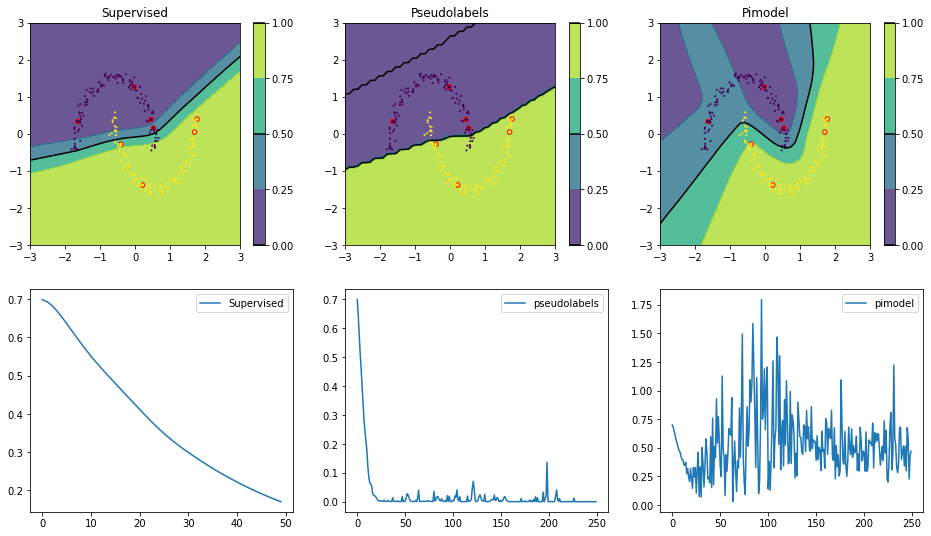

,supervised,pseudolabels,pimodel
test_accuracy,90.400002,90.800003,98.0


In [17]:
# Plot results
supervised_model.eval()
pseudo_model.eval()
pi_model.eval()

fig, axis = plt.subplots(2, 3, figsize=(16,9))
plot_contour(supervised_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][0])
plot_contour(pseudo_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][1])
plot_contour(pi_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][2])
axis[1][0].plot([d[f'train_loss'] for d in supervised_history], label=f'Supervised')
axis[1][1].plot([d[f'train_total_loss'] for d in pseudo_history], label=f'pseudolabels')
axis[1][2].plot([d[f'train_total_loss'] for d in pi_history], label=f'pimodel')

axis[1][0].legend()
axis[1][1].legend()
axis[1][2].legend()

axis[0][0].set_title("Supervised")
axis[0][1].set_title("Pseudolabels")
axis[0][2].set_title("Pimodel")

plt.show()

# Display final accuracys
pd.DataFrame(
    {
        'supervised':{'test_accuracy': evaluate(supervised_model, val_loader, {}, criterion, device='cuda')['test_acc1']},
        'pseudolabels':{'test_accuracy': evaluate(pseudo_model, val_loader, {}, criterion, device='cuda')['test_acc1']},
        'pimodel':{'test_accuracy': evaluate(pi_model, val_loader, {}, criterion, device='cuda')['test_acc1']}
    }
)